# Fitting in silico Marques to in vivo

**Purpose**: high background noise degrades spike sorting. We characterized in vivo background noise and validated ours against in vivo's.

**Data description**  
**in-vivo**:

* `Marques` (aligned with cortical column)
    * rat cortex S1
    * 384ch 
    * 30.0kHz
    * 20.25 min
    * "Spontaneous activity" (Only anesthetized condition)
    
**in-silico**:

* `Neuropixels` (aligned with cortical column)
    * rat cortex S1
    * 384ch 
    * 40.0kHz
    * 10 min
    * "Spontaneous activity" (Only anesthetized condition)


**Summary method**:

* In vivo traces' mean were removed, so we removed the mean from each recording site in silico.
* We fitted in silico preprocessed traces to in vivo preprocessed traces to match the 1) max voltage amplitude and 2) the average background noises per layer (minimum mean absolute deviation). The missing noise was modelled as independent noise on each site.
* The raw silico traces will be scaled and the missing noise added for all subsequent analyses.

**Pipelines to fit silico amplitude and noise to vivo per layer**:

```bash
sbatch cluster/processing/fitting/marques/fit_marques_silico_l1.sbatch
sbatch cluster/processing/fitting/marques/fit_marques_silico_l2_3.sbatch
sbatch cluster/processing/fitting/marques/fit_marques_silico_l4.sbatch
sbatch cluster/processing/fitting/marques/fit_marques_silico_l5.sbatch
sbatch cluster/processing/fitting/marques/fit_marques_silico_l6.sbatch
```

### Setup libs

Activate `npx_10m_384ch_unit_classes` venv

In [1]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
from concurrent.futures import ProcessPoolExecutor
import copy

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config


# SETUP PARAMETERS
RND_SEED = 0                # random seed
SFREQ_VIVO = 30000          # sampling frequency
SFREQ_SILICO = 40000        # sampling frequency
WIND_END = 3700             # last segment to calculate mad
SITE_VIVO = 383             # set a site in layer 1 (unbiased estimate of background noise because low activity?)
SITE_SILICO = 360           # set a site in layer 1 (unbiased estimate of background noise because low activity?)


# HORVATH (vivo)
EXPERIMENT_h_vivo = "vivo_marques"
SIMULATION_h_vivo = "c26"
data_conf_h_vivo, param_conf_h_vivo = get_config(
    EXPERIMENT_h_vivo, SIMULATION_h_vivo
).values() 
RAW_PATH_h_vivo = data_conf_h_vivo["raw"]
PREP_PATH_h_vivo = data_conf_h_vivo["preprocessing"]["output"]["trace_file_path"]
CONTACTS_h = np.arange(0,128,1)


# HORVATH (silico)
EXPERIMENT_h_silico = "silico_neuropixels"
SIMULATION_h_silico = "2023_10_18"
data_conf_h_silico, param_conf_h_silico = get_config(
    EXPERIMENT_h_silico, SIMULATION_h_silico
).values()
RAW_PATH_h_silico = data_conf_h_silico["dataeng"]["campaign"]["output"]["trace_file_path"]
PREP_PATH_h_silico = data_conf_h_silico["preprocessing"]["output"]["trace_file_path"]
MISSING_NOISE_PATH = data_conf_h_silico["preprocessing"]["fitting"]["missing_noise_path"]

2024-01-03 19:44:56,675 - root - utils.py - get_config - INFO - Reading experiment config.
2024-01-03 19:44:56,692 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-01-03 19:44:56,693 - root - utils.py - get_config - INFO - Reading experiment config.
2024-01-03 19:44:56,706 - root - utils.py - get_config - INFO - Reading experiment config. - done


In [2]:
### Custom


def get_layer_sites(silico_layers, layer: str = "L1"):
    if layer == "L2_3":
        return np.hstack(
            [np.where(silico_layers == "L2")[0], np.where(silico_layers == "L3")[0]]
        )
    else:
        return np.where(silico_layers == layer)[0]


def plot_example_one_sec_segments(traces, target_site=0, sfreq: int = 30000):
    """plot trace consecutive segments of one second
    Args:
        traces (np.ndarray): ntimepoints x n site traces
        target_site (np.ndarray): column index of a recording site
        sfreq (int): trace acquisition sampling frequency
    Return:
        plot
    """
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    winds = np.arange(0, 10, 1)
    for wind_i in winds:
        axes[wind_i].plot(traces[wind_i * sfreq : (wind_i + 1) * sfreq, target_site])
        axes[wind_i].set_ylim([-200, 200])
    return fig, axes


def measure_noise_at_consecutive_segs(traces, site, sfreq, wind_end):
    """measure noise (mean absolute deviation)
    at consecutive segments of 1 second
    """
    winds = np.arange(0, wind_end, 1)
    mads = []
    for wind_i in winds:
        segment = traces[wind_i * sfreq : (wind_i + 1) * sfreq, site]
        mads.append(pd.DataFrame(segment).mad().values[0])
    return mads


def measure_trace_noise(traces, sfreq, wind_end):
    """measure noise (mean absolute deviation)
    at consecutive segments of 1 second

    Args:
        traces: 2D array
    """
    winds = np.arange(0, wind_end, 1)
    mads = []
    for wind_i in winds:
        segment = traces[wind_i * sfreq : (wind_i + 1) * sfreq]
        mads.append(pd.DataFrame(segment).mad().values[0])
    return mads


def measure_vivo_trace_noise_parallel(traces_vivo, site):
    """Measure the minimum absolute deviation of a single trace
    over contiguous segments of one second
    "Site" is only used implicitly to pass each row of the
    traces_vivo matrix (the original timepoints x site matrix was transposed
    such that sites are in rows) to this function.

    Args:
        traces_vivo (np.array): a 1D trace array of site x timepoints
        site (int): the row used to implicitely extract that row from traces_vivo

    Returns:
        _type_: _description_
    """
    # each site row of the array is passed to a worker
    return min(measure_trace_noise(traces_vivo, SFREQ_VIVO, WIND_END))


def measure_silico_trace_noise_parallel(traces_silico, site):
    """Measure the minimum absolute deviation of a single trace
    over contiguous segments of one second
    "Site" is only used implicitly to pass each row of the
    traces_vivo matrix (the original timepoints x site matrix was transposed
    such that sites are in rows) to this function.

    Args:
        traces_silico (np.array): a 1D trace array of site x timepoints
        site (int): the row used to implicitely extract that row from traces_vivo

    Returns:
        _type_: _description_
    """
    # each site row of the array is passed to a worker
    return min(measure_trace_noise(traces_silico, SFREQ_SILICO, WIND_END))


Nfeval = 1


def myfun(missing_mad_std, *args):
    # get arguments
    trace_silico = args[0]
    mad_vivo = args[1]
    site_silico = args[2]

    # calculate missing noise for this x
    missing_noise = np.random.normal(0, missing_mad_std, [trace_silico.shape[0], 1])

    # return objective function abs(mad_vivo - mad_silico) to minimize
    mad_silico = (
        pd.DataFrame(trace_silico[:, site_silico] + missing_noise.squeeze())
        .mad()
        .values
    )
    return abs(mad_vivo - mad_silico)


def myfun_layer(missing_noise, *args):
    # get args
    # - get in silico target site traces
    # - get in vivo layer noise
    traces = args[0]
    vivo_noise = args[1]
    ntimepoints = traces.shape[1]
    nsites = traces.shape[0]

    # try with this amount of missing uncorrelated noise in silico
    missing_noise_traces = np.random.normal(0, missing_noise, [nsites, ntimepoints])
    with_noise = traces + missing_noise_traces

    # measure site noises in that in silico layer
    with ProcessPoolExecutor() as executor:
        sites_noise = executor.map(
            measure_silico_trace_noise_parallel,
            with_noise,
            np.arange(0, nsites, 1),
        )

    # minimize noise difference between vivo and silico
    silico_noise = np.mean(np.array(list(sites_noise)))
    objfun = abs(vivo_noise - silico_noise)
    print("silico noise:", silico_noise)
    print("objfun:", objfun)
    return objfun


def callback(Xi):
    """callback function to print iterations_summary

    Args:
        Xi (_type_): missing noise (mad) parameter to solve
    """
    global Nfeval  # function evaluation
    print(Xi)
    print("{0:4d}   {1: 3.6f}".format(Nfeval, Xi[0]))
    Nfeval += 1


def sem(data):
    return np.std(data) / np.sqrt(len(data))


def conf_interv95(data):
    return 1.96 * sem(data)

### Load fit results (if exists)

In [3]:
# if already fitted results exist
missing_noise_L1 = np.load(MISSING_NOISE_PATH + "L1.npy", allow_pickle=True).item()
missing_noise_L2_3 = np.load(MISSING_NOISE_PATH + "L2_3.npy", allow_pickle=True).item()
missing_noise_L4 = np.load(MISSING_NOISE_PATH + "L4.npy", allow_pickle=True).item()
missing_noise_L5 = np.load(MISSING_NOISE_PATH + "L5.npy", allow_pickle=True).item()
missing_noise_L6 = np.load(MISSING_NOISE_PATH + "L6.npy", allow_pickle=True).item()

# store missing noises
layers_missing_noise = (
    missing_noise_L1,
    missing_noise_L2_3,
    missing_noise_L4,
    missing_noise_L5,
    missing_noise_L6,
)

# print
print("fit result keys:", layers_missing_noise[0].keys())
print("fit result content:", layers_missing_noise)
print("fit result content:", layers_missing_noise[0]["fit_history"])

fit result keys: dict_keys(['scale', 'missing_noise_rms', 'layer_sites_ix', 'layer', 'fit_history', 'seed', 'missing_noise_traces'])
fit result content: ({'scale': 448.0834123444957, 'missing_noise_rms': 2.4921875, 'layer_sites_ix': [69, 70, 71, 72, 165, 166, 167, 168, 261, 262, 263, 264, 357, 358, 359, 360], 'layer': 'L1', 'fit_history': 'silico noise: 3.9757798520971708\nvivo noise: 2.027459498703704\nobjfun: 1.9483203533934668\n----------------\nsilico noise: 4.168026535401452\nvivo noise: 2.027459498703704\nobjfun: 2.1405670366977483\n----------------\nsilico noise: 3.778730689296564\nvivo noise: 2.027459498703704\nobjfun: 1.7512711905928602\n----------------\nsilico noise: 3.5817010743248847\nvivo noise: 2.027459498703704\nobjfun: 1.5542415756211807\n----------------\nsilico noise: 3.192209284539624\nvivo noise: 2.027459498703704\nobjfun: 1.16474978583592\n----------------\nsilico noise: 2.804390526117767\nvivo noise: 2.027459498703704\nobjfun: 0.7769310274140628\n----------------

### Scale, add noise to silico

In [11]:
# takes 10 mins
# set seed for reproducibility
np.random.seed(layers_missing_noise[0]["seed"])

# - get vivo traces
PreRecording_h_vivo = si.load_extractor(PREP_PATH_h_vivo)
traces_vivo = PreRecording_h_vivo.get_traces()

# - get silico traces
PreRecording_h_silico = si.load_extractor(PREP_PATH_h_silico)
traces_silico = PreRecording_h_silico.get_traces()

# - make writable
fitted_silico = copy.copy(traces_silico)

# - scale trace and add missing noise to each site
# according to its layer
for ix in range(len(layers_missing_noise)):
    # get sites
    sites = layers_missing_noise[ix]["layer_sites_ix"]

    # get scaling factor
    scale = layers_missing_noise[ix]["scale"]

    # reconstruct missing noise
    missing_noise = np.random.normal(
        0,
        layers_missing_noise[ix]["missing_noise_rms"],
        [len(sites), traces_silico.shape[0]],
    )

    # scale and add missing noise
    fitted_silico[:, sites] = traces_silico[:, sites] * scale + missing_noise.T

### Compute layer-wise noise

In [12]:
# takes 13 min (instead of 2 hours)

# VIVO

# measure site noise of in vivo traces (parallelized, )
with ProcessPoolExecutor() as executor:
    noise_by_trace = executor.map(
        measure_vivo_trace_noise_parallel,
        traces_vivo.T,
        np.arange(0, traces_vivo.shape[1], 1),
    )
vivo_noise_by_trace = list(noise_by_trace)

# SILICO

# measure site noise of fitted silico traces
with ProcessPoolExecutor() as executor:
    silico_noise_by_trace = executor.map(
        measure_silico_trace_noise_parallel,
        fitted_silico.T,
        np.arange(0, fitted_silico.shape[1], 1),
    )
silico_noise_by_trace = list(silico_noise_by_trace)

### Plot

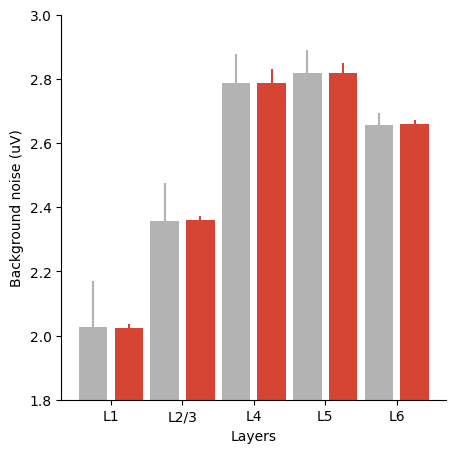

In [14]:
# plot layer-wise noise for vivo vs. silico

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

layers = ["L1", "L2_3", "L4", "L5", "L6"]
vivo_noise = []
ci_vivo = []
sili_noise = []
ci_sili = []

# - get site layers
silico_layers = PreRecording_h_silico.get_property("layers")
vivo_layers = PreRecording_h_vivo.get_property("layers")

# calculate noise stats by layer
for l_i in range(len(layers)):
    # VIVO

    vivo_noise.append(
        np.mean(np.array(vivo_noise_by_trace)[vivo_layers == layers[l_i]])
    )
    # confidence interval 95 of noise by layer
    ci_vivo.append(
        conf_interv95(np.array(vivo_noise_by_trace)[vivo_layers == layers[l_i]])
    )

    # SILICO

    sites = get_layer_sites(silico_layers, layer=layers[l_i])
    sili_noise.append(np.mean(np.array(silico_noise_by_trace)[sites]))
    ci_sili.append(conf_interv95(np.array(silico_noise_by_trace)[sites]))


# VIVO

ax.errorbar(
    x=[1, 2, 3, 4, 5],
    y=vivo_noise,
    yerr=ci_vivo,
    linestyle="None",
    color=[0.7, 0.7, 0.7],
)
ax.bar(
    x=[1, 2, 3, 4, 5],
    height=vivo_noise,
    width=0.4,
    facecolor=[0.7, 0.7, 0.7],
)
ax.set_xticks([1, 2, 3, 4, 5])

# SILICO

ax.errorbar(
    x=[1.5, 2.5, 3.5, 4.5, 5.5],
    y=sili_noise,
    yerr=ci_sili,
    linestyle="None",
    color=(0.84, 0.27, 0.2),
)
ax.bar(
    x=[1.5, 2.5, 3.5, 4.5, 5.5],
    height=sili_noise,
    width=0.4,
    facecolor=(0.84, 0.27, 0.2),
)

ax.set_xticks([1.25, 2.25, 3.25, 4.25, 5.25])
ax.set_xticklabels(["L1", "L2/3", "L4", "L5", "L6"])
ax.set_ylim([1.8, 3])
ax.set_box_aspect(1)  # square axis
ax.spines[["top", "right"]].set_visible(False)
ax.set_xlabel("Layers")
ax.set_ylabel("Background noise (uV)")

# # save figures
plt.savefig("figures/2_realism/2_noise/pdf/layerwise_noise_stats_marques.pdf")
plt.savefig("figures/2_realism/2_noise/svg/layerwise_noise_stats_marques.svg")